In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
from sklearn import datasets
sess = tf.Session()
%matplotlib inline

In [68]:
#load data, extract speal length and pedal width
iris = datasets.load_iris()
x_vals = iris.data[:,[0,3]]
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

In [72]:
#declare batch size and variables etc.
batch_size = 100

x_data = tf.placeholder(dtype=tf.float32,shape=[None,2])
y_target = tf.placeholder(dtype=tf.float32,shape=[None,1])
prediction_grid = tf.placeholder(dtype=tf.float32,shape=[None,2])

b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

In [73]:
#declare gaussian kernel
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data),1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b),b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term,second_term))

In [84]:
#create prediction kernel function
rA = tf.reshape(tf.reduce_sum(tf.square(x_data),1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,tf.transpose(prediction_grid)))),tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b),pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediciton),tf.squeeze(y_target)),tf.float32))

In [85]:
#optimizer
opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)
init = tf.initialize_all_variables()
sess.run(init)

In [86]:
loss_vec = []
batch_accuracy =[]

for i in range(300):
    rand_index = np.random.choice(len(x_vals),batch_size)
    rand_x = x_vals[rand_index].reshape((-1,2))
    rand_y = y_vals[rand_index].reshape((-1,1))
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)

In [87]:
#create mesh of x,y
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(),yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid:grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

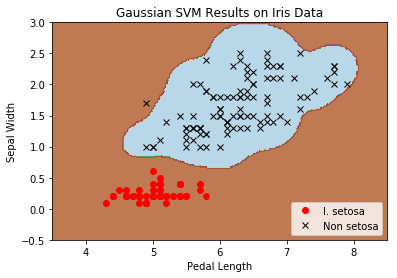

In [88]:
#plot 
plt.contourf(xx,yy,grid_predictions,cmap=plt.cm.Paired,alpha=0.8)
plt.plot(class1_x,class1_y,'ro',label='I. setosa')
plt.plot(class2_x,class2_y,'kx',label='Non setosa')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5,3])
plt.xlim([3.5,8.5])
plt.show()